# MESCAL 101: StudyManager and Dataset Fundamentals

## Introduction

This notebook demonstrates the core functionality of MESCAL's StudyManager - the central component for handling multiple scenarios and scenario comparisons in energy system modeling studies. It showcases how MESCAL's architecture simplifies working with complex multi-scenario analyses through a consistent and powerful interface.

Rather than juggling separate data structures for each scenario, MESCAL provides a unified framework where:
- Every data element is accessible through a consistent API
- Scenarios and comparisons are handled through the same paradigm
- Data relationships are automatically preserved and utilized

We'll use PyPSA's Scigrid DE example dataset for this demonstration, but the same principles apply regardless of which modeling platform you use.


## Setup

In [1]:
import os
import logging
import warnings
import pandas as pd
import pypsa
from IPython.display import Image

from mescal import StudyManager
from mescal.utils.plotly_utils.plotly_theme import PlotlyTheme
from mescal_pypsa import PyPSADataset

# Directory setup
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

# Configuration for cleaner output
logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', 6)
pd.set_option('display.width', 1000)
PlotlyTheme().apply()

In [2]:
# Register study-specific interpreters (details on this will be covered in a later notebook)
from studies.study_01_intro_to_mescal.src.study_specific_model_interpreters import ControlAreaModelInterpreter, ScigridDEBusModelInterpreter

PyPSADataset.register_interpreter(ControlAreaModelInterpreter)
PyPSADataset.register_interpreter(ScigridDEBusModelInterpreter)

## Loading Example Data

For this demonstration, we use a PyPSA Scigrid DE example with a base network and four scenarios with increased solar and wind capacity. All networks have already been optimized.

In [3]:
# Loading networks (all have already been optimized, so the results are included)
study_folder = 'studies/study_01_intro_to_mescal'
networks_folder = os.path.join(study_folder, 'data/networks_scigrid_de')

n_base = pypsa.Network(os.path.join(networks_folder, 'base.nc'))
n_solar_150 = pypsa.Network(os.path.join(networks_folder, 'solar_150.nc'))
n_solar_200 = pypsa.Network(os.path.join(networks_folder, 'solar_200.nc'))
n_wind_150 = pypsa.Network(os.path.join(networks_folder, 'wind_150.nc'))
n_wind_200 = pypsa.Network(os.path.join(networks_folder, 'wind_200.nc'))

## The StudyManager

The StudyManager is the central component of MESCAL, organizing all scenarios and scenario comparisons for efficient access and analysis.

In [4]:
study = StudyManager.factory_from_scenarios(
    scenarios=[
        PyPSADataset(n_base,        name='base'),
        PyPSADataset(n_solar_150,   name='solar_150'),
        PyPSADataset(n_solar_200,   name='solar_200'),
        PyPSADataset(n_wind_150,    name='wind_150'),
        PyPSADataset(n_wind_200,    name='wind_200'),
    ],
    comparisons=[('solar_150', 'base'), ('solar_200', 'base'), ('wind_150', 'base'), ('wind_200', 'base')],
    export_folder=os.path.join(study_folder, 'non_versioned/output'),
)

In just a few lines of code, we've organized all scenarios and defined which comparisons we're interested in (here, comparing each scenario to the base case).

## The Dataset Concept

The core building block in MESCAL is the Dataset class. The key insight is that:

### Everything is a Dataset!

- Individual scenarios are Datasets
- Collections of scenarios are Datasets
- Scenario comparisons are Datasets
- Collections of comparisons are Datasets

This means you interact with all entities through a consistent interface, regardless of whether you're working with a single scenario or a complex collection of scenario comparisons.

## Working with Datasets

Let's explore the fundamental operations with Datasets:

### Accessing a Single Dataset

In [5]:
ds_base = study.scen.get_dataset('base')

### Fetching Data 

The primary method for interacting with Datasets is the `fetch()` method:

In [6]:
df_price_base = ds_base.fetch('buses_t.marginal_price')
print(df_price_base.head())

Bus                         1        10        100  ...        98         99   99_220kV
snapshot                                            ...                                
2011-01-01 00:00:00 -0.439753  5.772135  23.120287  ...  1.890824  23.723792  23.685443
2011-01-01 01:00:00 -0.578449  6.100599  22.531275  ...  1.960914  23.186991  23.144293
2011-01-01 02:00:00 -0.582087  6.071084  22.106222  ...  1.954744  22.747326  22.705514
2011-01-01 03:00:00 -0.596210  6.139415  21.498113  ...  1.995093  22.117870  22.077360
2011-01-01 04:00:00 -0.609622  6.164469  20.391625  ...  2.031251  20.979582  20.940890

[5 rows x 585 columns]


For PyPSA users, note that this produces the same output as `n_base.buses_t.marginal_price` but provides a consistent interface across all platforms.

### Discovering Available Data

To see what data is available in a Dataset:

In [7]:
accepted_flags = ds_base.accepted_flags
list(sorted(accepted_flags))[:15]  # Just showing the first 15

['buses',
 'buses_t.marginal_price',
 'buses_t.p',
 'buses_t.q',
 'buses_t.v_ang',
 'buses_t.v_mag_pu',
 'buses_t.v_mag_pu_set',
 'carriers',
 'control_areas',
 'generators',
 'generators_t.efficiency',
 'generators_t.marginal_cost',
 'generators_t.marginal_cost_quadratic',
 'generators_t.mu_lower',
 'generators_t.mu_p_set']

Or to find specific types of data:

In [8]:
accepted_flags_for_lines = ds_base.get_accepted_flags_containing_x('lines')
accepted_flags_for_lines

{'lines',
 'lines_t.mu_lower',
 'lines_t.mu_upper',
 'lines_t.p0',
 'lines_t.p1',
 'lines_t.q0',
 'lines_t.q1',
 'lines_t.s_max_pu'}

## From Simple to Powerful: Scenario Collections

While the individual Dataset interface is useful, MESCAL's true power emerges when working with multiple scenarios.

Let's fetch the marginal price data for all scenarios at once:

In [9]:
df_price = study.scen.fetch('buses_t.marginal_price')
print(df_price.head())

dataset                  base                       ...  wind_200                      
Bus                         1        10        100  ...        98         99   99_220kV
snapshot                                            ...                                
2011-01-01 00:00:00 -0.439753  5.772135  23.120287  ...  0.072306  23.828566  23.794191
2011-01-01 01:00:00 -0.578449  6.100599  22.531275  ... -0.056472  22.380868  22.329086
2011-01-01 02:00:00 -0.582087  6.071084  22.106222  ... -0.052310  20.490690  20.442924
2011-01-01 03:00:00 -0.596210  6.139415  21.498113  ... -0.152777  18.640298  18.596510
2011-01-01 04:00:00 -0.609622  6.164469  20.391625  ... -0.120450  15.923631  15.889469

[5 rows x 2925 columns]


The result is a MultiIndex DataFrame with an additional 'dataset' level containing all scenario data in a single structure.

## Scenario Comparisons

Similarly, we can get comparison data (deltas between scenarios):


In [10]:
df_price_change = study.comp.fetch('buses_t.marginal_price')
print(df_price_change.head())

dataset             solar_150 vs base                      ... wind_200 vs base                    
Bus                                 1        10       100  ...               98        99  99_220kV
snapshot                                                   ...                                     
2011-01-01 00:00:00          0.209435  0.022953  0.020959  ...        -1.818518  0.104774  0.108749
2011-01-01 01:00:00          0.017964  0.064642 -0.080598  ...        -2.017386 -0.806122 -0.815207
2011-01-01 02:00:00          0.013235  0.082471 -0.002842  ...        -2.007054 -2.256636 -2.262590
2011-01-01 03:00:00          0.026943  0.012270 -0.156701  ...        -2.147870 -3.477572 -3.480850
2011-01-01 04:00:00          0.000889 -0.124771 -0.887855  ...        -2.151701 -5.055950 -5.051421

[5 rows x 2340 columns]


Each column in this DataFrame represents the difference between a variation scenario and the base scenario.

## Visualization Example

Now let's see this in action with a visualization. We'll create a unified analysis of average generation by carrier, control area, and scenario:


2025-03-01 15:43:36,916 - mescal_pypsa.pypsa_flag_index - WARNING - No model flag registered for membership_column bus. Auto-assumption buses


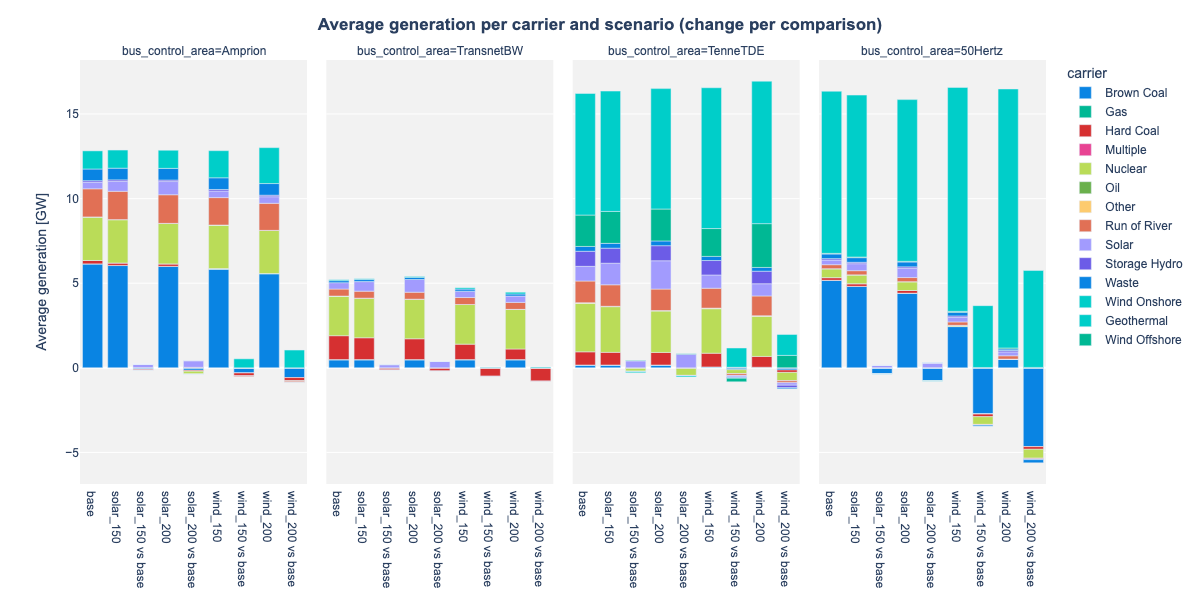

In [11]:
import plotly.express as px
from mescal.utils.pandas_utils import flatten_df, prepend_model_prop_levels, filter_by_model_query

generators_model_df = study.scen.get_dataset('base').fetch('generators')
data = study.scen_comp.fetch('generators_t.p')
data = prepend_model_prop_levels(data, generators_model_df, 'bus_control_area', 'carrier')
data = data.mean().groupby(level=['dataset', 'bus_control_area', 'carrier']).sum()
data = data / 1e3  # MW to GW
data_flat = data.to_frame('value').reset_index()
fig = px.bar(
    data_frame=data_flat,
    y='value',
    x='dataset',
    facet_col='bus_control_area',
    color='carrier',
    category_orders={'bus_control_area': ['Amprion', 'TransnetBW', 'TenneTDE', '50Hertz']},
    labels={'value': 'Average generation [GW]'},
)
fig.update_layout(title='<b>Average generation per carrier and scenario (change per comparison)</b>', width=1200)
fig.update_xaxes(title=None)

# Save and display the image
image_path = study.export_path('generation_barchart.png')
fig.update_layout(height=600, width=1200)
fig.write_image(image_path)
Image(image_path)

## Key Takeaways

- **Unified Interface**: Whether working with individual scenarios or complex collections, the same methods apply
- **Efficient Analysis**: Analyze multiple scenarios with the same code you'd use for one
- **Automatic Comparison**: Calculate scenario deltas without manual calculations
- **Hierarchical Organization**: Study → Scenarios → Individual Datasets provides a logical structure
- **Consistency Across Platforms**: The same code works regardless of your modeling platform

In the next notebook, we'll explore more advanced data fetching and transformation techniques that build on these fundamentals.
